# satCORPS composite Sorting and Saving in a STARE-sorted formated

- Uses starepandas branch granular_democracy


In [1]:
import os
os.environ['PROJ_LIB'] = '/homelocal/mrilee/opt/anaconda3/envs/stare-1/share/proj'

import pystare
import starepandas
import geopandas
import pandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import pickle

import datetime

import regionmask
import xarray
from shapely.geometry import Polygon

import dask

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}


In [2]:
class timings_store:
    def __init__(self):
        self.timings = {}
        return
   
    def add(self,key,value,verbose=True):
        self.timings[key] = value
        if verbose:
            print("{} {}".format(key,value))
        return self
    
    def print_report(self,fmt="{:30} {:>6.2f}",key=None,grepv=None):
        for i, (k,v) in enumerate(self.timings.items()):
            if key is None:
                if not grepv is None:
                    if not grepv in k:
                        print(fmt.format(k,v.total_seconds()))
                else:
                    print(fmt.format(k,v.total_seconds()))
            else:
                if key in k:
                    if not grepv is None:
                        if not grepv in k:
                            print(fmt.format(k,v.total_seconds()))
                    else:
                        print(fmt.format(k,v.total_seconds()))
        return self
    
timings = timings_store()

# timings.print_report(fmt="{:70} {:>6.2f}")   

## Create and install a user defined granule loader to plug into starepandas

In [3]:
from starepandas.io.granules import Granule

class satcorps_composite(Granule):

    def __init__(self, file_path, sidecar_path=None):
        super(satcorps_composite, self).__init__(file_path, sidecar_path)
        self.nom_res = ''
        self.companion_prefix = 'composite'
        
        self.source_nc = starepandas.io.s3.nc4_dataset_wrapper(self.file_path, 'r', format='NETCDF4')
        self.lat = None
        self.lon = None
        self.data = {}

    def read_data(self):
        if False:
            dataset_names = ['time' # "days since 1858-11-17T00:00:00.000"
                             ,'map_data/BT_10.8um']

            for dataset_name in dataset_names:
                self.data[dataset_name] = self.source_nc.select(dataset_name).get()
        
#        self.data['time'] = self.source_nc['time'][:].astype(numpy.double)

        ds_names = {
            'BT_10_8um':'BT_10.8um',
            'BT_12_0um':'BT_12.0um',
            'BT_3_75um':'BT_3.75um',
            'BT_6_75um':'BT_6.75um'
        }
        for ds_name in ds_names.keys():
            self.data[ds_name] = self.source_nc.groups['map_data'][ds_names[ds_name]][:].astype(numpy.double)
    
        lat = self.source_nc.groups['map_data']['lat'][:].astype(numpy.double); nlat=len(lat)
        lon = self.source_nc.groups['map_data']['lon'][:].astype(numpy.double); nlon=len(lon)
        self.data['lats'] = numpy.ascontiguousarray(numpy.tile(lat,(nlon,1)).transpose())
        self.data['lons'] = numpy.tile(lon,(nlat,1))

starepandas.io.granules.granule_factory_library['composite']=satcorps_composite

starepandas.io.granules.granule_factory_library

{'MOD05|MYD05': starepandas.io.granules.modis.Mod05,
 'MOD09|MYD09': starepandas.io.granules.modis.Mod09,
 'VNP02DNB|VJ102DNB': starepandas.io.granules.viirsl2.VNP02DNB,
 'VNP03DNB|VJ103DNB': starepandas.io.granules.viirsl2.VNP03DNB,
 'VNP03MOD|VJ103MOD': starepandas.io.granules.viirsl2.VNP03MOD,
 'CLDMSKL2VIIRS': starepandas.io.granules.viirsl2.CLDMSKL2VIIRS,
 'SSMIS': starepandas.io.granules.ssmis.SSMIS,
 'ATMS': starepandas.io.granules.atms.ATMS,
 'composite': __main__.satcorps_composite}

## Load the granule, adding STARE information from the sidecar file

!wget https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip

In [4]:
start0 = datetime.datetime.now()

In [5]:
# Load the granule
if True:
    granule_name = 'ignored/satCORPS/composite_20220420_2019.182.0230.nc'
    composite = starepandas.read_granule(granule_name
                                         ,sidecar=True
                                         ,sidecar_path='ignored/satCORPS/satCORPS_composite_stare.nc')
    timings.add('time to read granule with stare sidecar',datetime.datetime.now() - start0)

time to read granule with stare sidecar 0:00:16.933237


## Sort the data by the STARE HTM indices and save to a file

In [6]:
start0 = datetime.datetime.now()

In [7]:
composite_sorted = composite.sort_values('sids')
# composite_sorted
timings.add('time to sort data into stare order',datetime.datetime.now()-start0)

time to sort data into stare order 0:00:10.516419


In [8]:
composite_sorted.to_hdf('composite.h5','stare_sorted',format='fixed',data_columns=['sids','BT_12_0um','lats','lons'])

In [9]:
timings.add('time to sort & save data in stare-sorted format (no pods-index)',datetime.datetime.now() - start0)

time to sort & save data in stare-sorted format (no pods-index) 0:00:16.170340


## Determine offsets to STARE 'chunks' in the data

- Determine intervals (of array indices) covering data in trixels of a given level
- Code not verified (do more testing later)


In [10]:
def hex16(i):
    return "0x%016x"%i

In [11]:
def binary_find(s,a):
    n=len(a)
    c=int(n/2)
    d=int(n/2)
    while d>0:
        # print(s,c,d,a.iloc[c])
        d = int(d/2)
        if s > a.iloc[c]:
            c += d
        elif s < a.iloc[c]:
            c -= d
        else:
            d=0
    return c-1

class chunk_lite:
    def __init__(self,start,stop):
        self.start = start
        self.stop  = stop
        return

class pods_map_factory:
    def __init__(self,level=None):
        self.pods_lite_level = 5 if level is None else level
        self.level_increment = pystare.spatial_increment_from_level(self.pods_lite_level)
        self.nsids_at_level = (8 * (4**self.pods_lite_level))
        self.sids_at_level = numpy.zeros([self.nsids_at_level],dtype=numpy.int64)

        k = 0
    # Plot each increment (overlay on common axes)
        for siv_idx, siv in enumerate(range(0, self.nsids_at_level*self.level_increment, self.level_increment)):
            siv = siv + level # Set the level
            self.sids_at_level[k] = siv
            # print(k,siv,hex16(siv))
            k += 1
        return
    
    def map_data(self,sorted_data):
        self.pods_lite    = {}
        self.stare_bounds = {}
    
        for k in range(0,self.nsids_at_level):
            start = binary_find(self.sids_at_level[k],sorted_data['sids'])
            stop  = binary_find(pystare.spatial_terminator(self.sids_at_level[k]),sorted_data['sids'])
            if start != stop:
                self.pods_lite[self.sids_at_level[k]] = chunk_lite(start,stop)

            if False:
                for k in self.pods_lite.keys():
                    print(hex16(k),self.pods_lite[k].start,self.pods_lite[k].stop)
        return self.pods_lite
    
    def to_file(self,filename=None):
        self.filename = 'pods_map.pkl' if filename is None else filename
        with open( self.filename, 'wb' ) as f:
            pickle.dump(self.pods_lite,f)
        return
    
def read_hdf(data_filename,sids,pods_map_filename):
    pods_map_filename = 'pods_map.pkl' if pods_map_filename is None else pods_map_filename
    
    start1 = datetime.datetime.now()
    with open( pods_map_filename, 'rb' ) as f:
        pods_lite = pickle.load(f)
    print('time to load pods map: ',datetime.datetime.now() - start1)
    
    resolution = int(pystare.spatial_resolution(list(pods_lite.keys())[0]))
    
    idx = numpy.unique(
        pystare.spatial_clear_to_resolution(
            pystare.spatial_coerce_resolution(pystare.expand_intervals(sids,resolution),resolution)))
                                              
    # print(idx)
    dfs = []
    for s in idx:
        chunk = pods_lite[s]
        df = pandas.read_hdf(data_filename,start=chunk.start+2,stop=chunk.stop) # why the +2?
        dfs.append(df)
        
    return pandas.concat(dfs)

## Construct the offset map for a given resolution level.

In [12]:
start0 = datetime.datetime.now()

In [13]:
pods_map_maker = pods_map_factory(level=5)

In [14]:
pods_lite = pods_map_maker.map_data(composite_sorted)

In [15]:
pods_map_maker.to_file()

In [16]:
timings.add('time to construct and save',datetime.datetime.now() - start0)

time to construct and save 0:00:02.511150


In [17]:
del pods_lite

## Check by loading the pods_map of offsets back in.

In [18]:
with open( 'pods_map.pkl', 'rb' ) as f:
    pods_lite = pickle.load(f)

In [19]:
sid = 562949953421317
pods_lite[sid].start,pods_lite[sid].stop

(6265, 12695)

## Load the data for some trixels to test.

In [20]:
if False:
    resolution = 1
    increment_at_level   = pystare.spatial_increment_from_level(resolution)
    increment_at_levelp1 = pystare.spatial_increment_from_level(resolution+1)
    trixels = [
        0*increment_at_level+2*increment_at_levelp1+resolution
        ,1*increment_at_level+3*increment_at_levelp1+resolution
        ,2*increment_at_level+3*increment_at_levelp1+resolution
        ,3*increment_at_level+3*increment_at_levelp1+resolution
    ]
    print('trixels: ',list(map(hex16,trixels)))
    
if True:
    resolution = 0
    increment_at_level   = pystare.spatial_increment_from_level(resolution)
    increment_at_levelp1 = pystare.spatial_increment_from_level(resolution+1)
    trixels = [
        1*increment_at_level + 1*increment_at_levelp1 + resolution + 1
    ]
    print('trixels: ',list(map(hex16,trixels)))

trixels:  ['0x0a00000000000001']


In [21]:
start0 = datetime.datetime.now()
df = read_hdf('composite.h5',trixels,None); df
timings.add('time to load data',datetime.datetime.now()-start0)

time to load pods map:  0:00:00.009402
time to load data 0:00:01.395908


In [22]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=180.0)
                ,'transform': ccrs.Geodetic()}

time to start plot 0:00:00.350299


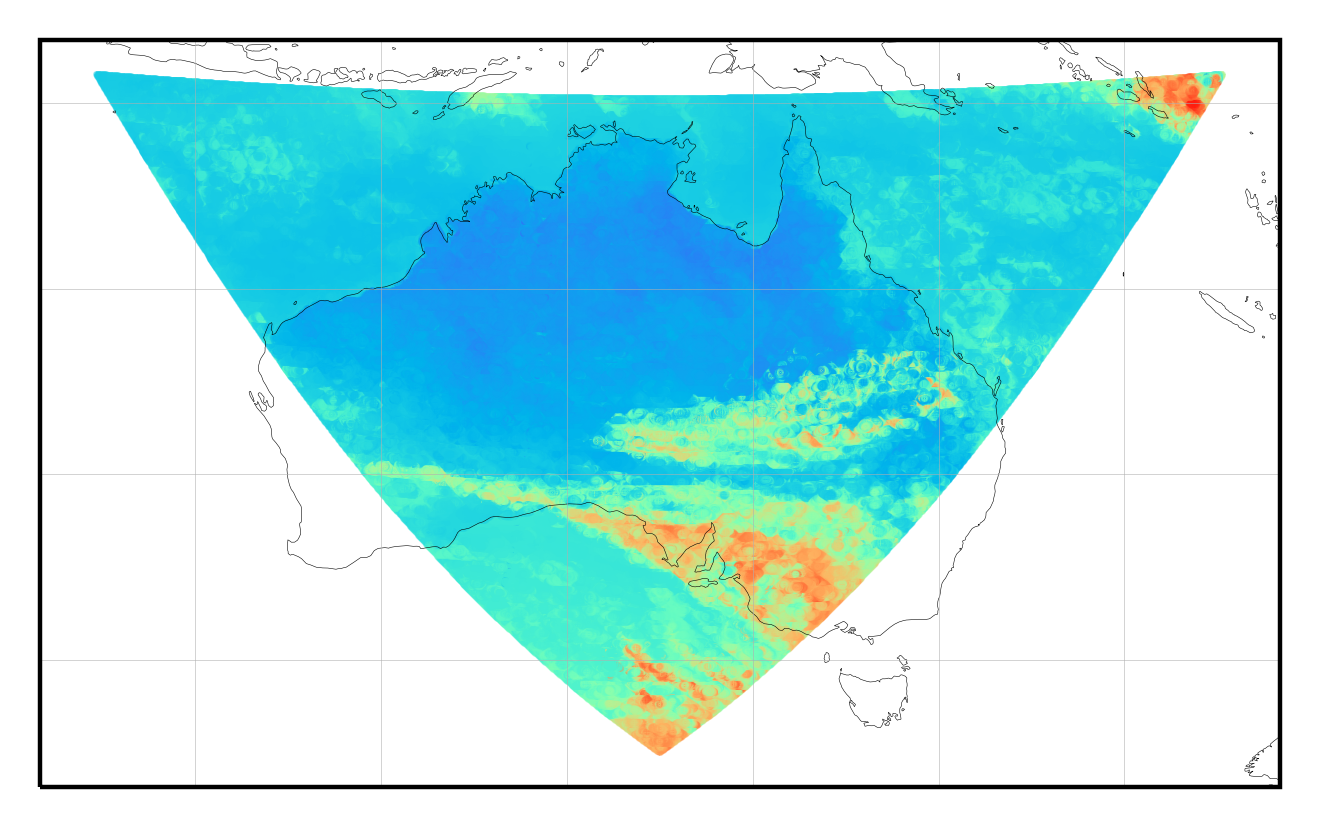

In [23]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

# Doesn't work for 1-D data
# ax.contourf(df['lons'],df['lats'],df['BT_12_0um']
#            ,cmap='nipy_spectral'
#            ,cmap='rainbow'
#            ,transform=ccrs.PlateCarree()
#        )
if True:
    ax.scatter(df['lons'],df['lats']
                ,s=marker_size
                ,c=df['BT_12_0um']
                ,alpha=marker_alpha
    #            ,cmap='nipy_spectral'
                ,cmap='rainbow_r'
                ,marker=marker
                ,rasterized=True
                ,transform=ccrs.PlateCarree()
                )
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

timings.add('time to start plot',datetime.datetime.now()-start0)

In [24]:
timings.add('total time to plot',datetime.datetime.now()-start0)

total time to plot 0:00:05.950711


## Timings summary report

In [25]:
timings.print_report(fmt="{:70} {:>6.2f}") 

time to read granule with stare sidecar                                 16.93
time to sort data into stare order                                      10.52
time to sort & save data in stare-sorted format (no pods-index)         16.17
time to construct and save                                               2.51
time to load data                                                        1.40
time to start plot                                                       0.35
total time to plot                                                       5.95
